# CVAE Modeling

In [11]:
import torch
import numpy as np
from utils.dataload import prepare_data_loaders, set_seed
from utils.functions import load_best_params, pca, train_cvae, save_model, load_model, display_spectrums, cvae_reconstruction, cvae_latent_3d, cvae_latent_2d, vae_latent_interpolation, print_top_latent_std, cvae_latent_umap
import numpy as np
from CVAE.cvae import CVAE
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
print(torch.cuda.is_available())        # True
print(torch.cuda.get_device_name(0))    # Nom du GPU
set_seed(42) 

True
NVIDIA T400 4GB


## CVAE Training

In [12]:
# Chargement des meilleurs paramètres
# ============================================================
latent_dim, hidden_dim_list, lr, dropout = load_best_params(json_path="best_params.json")

Best parameters found:
Latent dimension: 20
Hidden dimensions: [1024, 512, 256, 128]
Learning rate: 0.001
Dropout rate: 0


Data loaded and normalized. Returning dataset.
Train dataset size: 7841
Test dataset size: 1960
X_batch shape: torch.Size([128, 4])
y_batch shape: torch.Size([128, 5000])
labels_batch shape: torch.Size([128, 1])


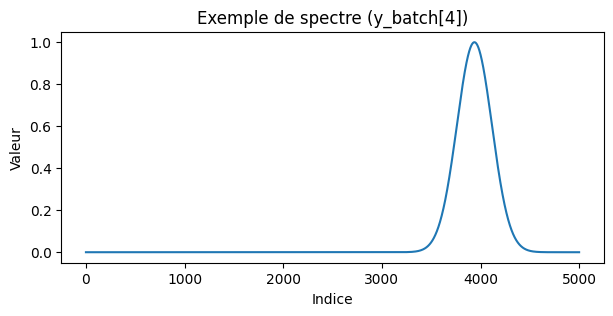

dim_x: 4
dim_y: 5000
Input dimension: 5004
Using device: cuda


In [13]:
# Data loading and preparation
# ============================================================
dataloader_train, dataloader_test, dataset, train_dataset, test_dataset, scaler_x, dim_x, dim_y, input_dim, device = prepare_data_loaders(batch_size=128, test_ratio=0.2, plot_example=True, seed=42)

In [4]:
# Analyse PCA
# ============================================================
pca(dataset)

Shape of concatenated data (X, Y): (9801, 5004)
Nombre de composantes pour 99% de variance : 16


Epoch 1/800, Train Loss: 0.0873, Val Loss: 0.0595
Epoch 2/800, Train Loss: 0.0498, Val Loss: 0.0484
Epoch 3/800, Train Loss: 0.0449, Val Loss: 0.0424
Epoch 4/800, Train Loss: 0.0418, Val Loss: 0.0413
Epoch 5/800, Train Loss: 0.0409, Val Loss: 0.0398
Epoch 6/800, Train Loss: 0.0380, Val Loss: 0.0391
Epoch 7/800, Train Loss: 0.0369, Val Loss: 0.0366
Epoch 8/800, Train Loss: 0.0356, Val Loss: 0.0353
Epoch 9/800, Train Loss: 0.0337, Val Loss: 0.0341
Epoch 10/800, Train Loss: 0.0331, Val Loss: 0.0338
Epoch 11/800, Train Loss: 0.0327, Val Loss: 0.0331
Epoch 12/800, Train Loss: 0.0319, Val Loss: 0.0318
Epoch 13/800, Train Loss: 0.0301, Val Loss: 0.0311
Epoch 14/800, Train Loss: 0.0302, Val Loss: 0.0395
Epoch 15/800, Train Loss: 0.0307, Val Loss: 0.0300
Epoch 16/800, Train Loss: 0.0280, Val Loss: 0.0292
Epoch 17/800, Train Loss: 0.0281, Val Loss: 0.0271
Epoch 18/800, Train Loss: 0.0272, Val Loss: 0.0294
Epoch 19/800, Train Loss: 0.0262, Val Loss: 0.0283
Epoch 20/800, Train Loss: 0.0260, Val Lo

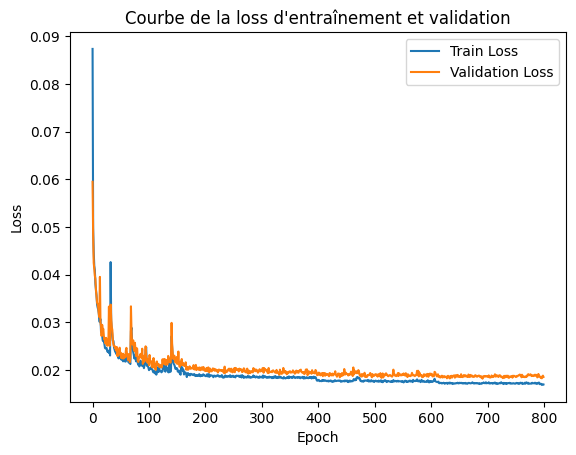

In [44]:
# Initialisation du modèle et de l'optimiseur
# ============================================================
cvae = CVAE(input_dim=input_dim, cond_dim=1, latent_dim=latent_dim, hidden_dim_list=hidden_dim_list, dropout=dropout, beta=0.1).to(device)

optimizer = torch.optim.Adam(cvae.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, min_lr=1e-6)

num_epochs = 800

train_cvae(cvae, optimizer, scheduler, num_epochs, dataloader_train, dataloader_test, device)


In [45]:
# Sauvegarde du modèle entraîné
# ============================================================
model_path = "saved_models/cvae_trained_20_0.1.pth"
save_model(cvae, optimizer, model_path, input_dim, latent_dim, hidden_dim_list, dropout, scaler_x)

Modèle sauvegardé sous saved_models/cvae_trained_20_0.1.pth


# Chargement du modèle

In [46]:
# Chargement du modèle entraîné
# ============================================================
model_path = "saved_models/cvae_trained_20_0.1.pth"
cvae, optimizer_state_dict, scaler_x, device = load_model(model_path)

Paramètres du modèle chargés :
Input dimension: 5004
Latent dimension: 20
Hidden dimensions: [1024, 512, 256, 128]
Dropout rate: 0
Modèle chargé avec succès.


recon_x shape: (128, 4)
recon_y shape: (128, 5000)
X normalisé: [-0.20802161 -0.29780027 -1.2009788   1.1552272 ]
Y normalisé: [0.4909484  0.4910891  0.4912665  ... 0.65532225 0.65498424 0.654286  ]
orig_x shape: (128, 4)
orig_y shape: (128, 5000)
X normalisé: [-0.0364626  -1.2878724   0.7965808  -0.85780776]
Y normalisé: [0.41607887 0.41630778 0.41653675 ... 0.76829225 0.7680743  0.76785624]


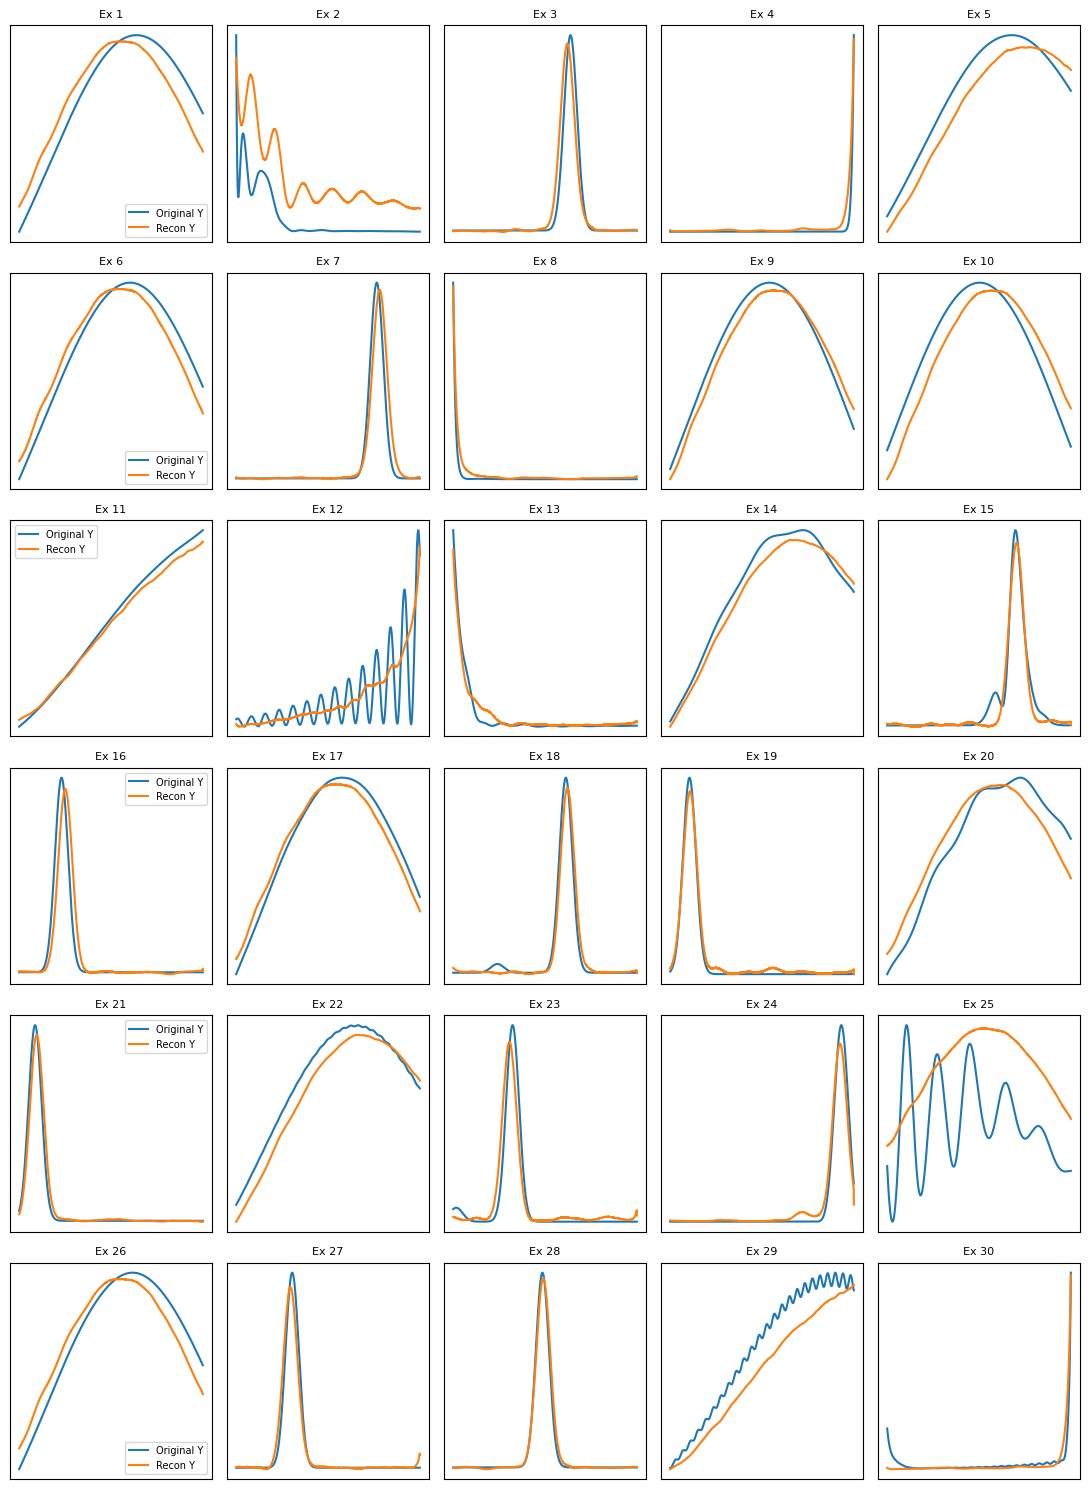

In [47]:
# Reconstruction des données de test
# ============================================================
orig_x, orig_y, recon_x, recon_y = cvae_reconstruction(cvae, dataloader_test, device, dim_x)

n_examples = 30
display_spectrums(n_examples, orig_y, recon_y)

In [48]:
# Visualisation des composantes latentes actives
# ============================================================
z_list = []
cvae.eval()
with torch.no_grad():
    for x_batch, y_batch, label_batch in dataloader_train:
        xy_batch = torch.cat([x_batch, y_batch], dim=1).to(device)
        label_batch = label_batch.to(device)
        mu, logvar = cvae.encode(xy_batch, label_batch)
        z_list.append(mu.cpu())  # stocke les mu (sans reparam.)
# Concatène tous les z en un seul tensor
z_train = torch.cat(z_list, dim=0)  # shape [N, latent_dim]

print("Shape of z_train:", z_train.shape)
std = z_train.std(dim=0)
top3_indices = print_top_latent_std(std, top_n=3)


Shape of z_train: torch.Size([7841, 20])
Std of z_train (sorted):
z[14] : 0.9912
z[13] : 0.0049
z[16] : 0.0033
z[2] : 0.0032
z[8] : 0.0032
z[11] : 0.0031
z[18] : 0.0029
z[3] : 0.0028
z[5] : 0.0027
z[19] : 0.0026
z[4] : 0.0025
z[9] : 0.0025
z[6] : 0.0024
z[1] : 0.0024
z[15] : 0.0024
z[17] : 0.0024
z[7] : 0.0023
z[0] : 0.0023
z[10] : 0.0022
z[12] : 0.0022

Indices des 3 plus grandes std : [14 13 16]


In [49]:
# Visualisation 3D des données dans l'espace latent
# ============================================================
dataloader_test_big = DataLoader(test_dataset, batch_size=1024, shuffle=False)

index1, index2, index3 = top3_indices[0], top3_indices[1], top3_indices[2]
cvae_latent_3d(cvae, dataloader_test_big, index1=index1, index2=index2, index3=index3, color_mode="peak_pos", index4=None, device=device)

In [50]:
cvae_latent_3d(cvae, dataloader_test_big, index1=index1, index2=index2, index3=index3, color_mode="sum", device=device)

In [51]:
cvae_latent_3d(cvae, dataloader_test_big, index1=index1, index2=index2, index3=index3, color_mode="label", device=device)

In [52]:
cvae_latent_umap(cvae, dataloader_test_big, color_mode="peak_pos", device=None, n_neighbors=15, min_dist=0.1, metric="euclidean")

C:\Users\gabriel.legros\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\gabriel.legros\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [53]:
cvae_latent_umap(cvae, dataloader_test_big, color_mode="sum", device=None, n_neighbors=15, min_dist=0.1, metric="euclidean")

C:\Users\gabriel.legros\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\gabriel.legros\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [54]:
cvae_latent_umap(cvae, dataloader_test_big, color_mode="label", device=None, n_neighbors=15, min_dist=0.1, metric="euclidean")

C:\Users\gabriel.legros\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\gabriel.legros\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



x_batch shape: torch.Size([1024, 4])
y_batch shape: torch.Size([1024, 5000])
label_batch shape: torch.Size([1024, 1])


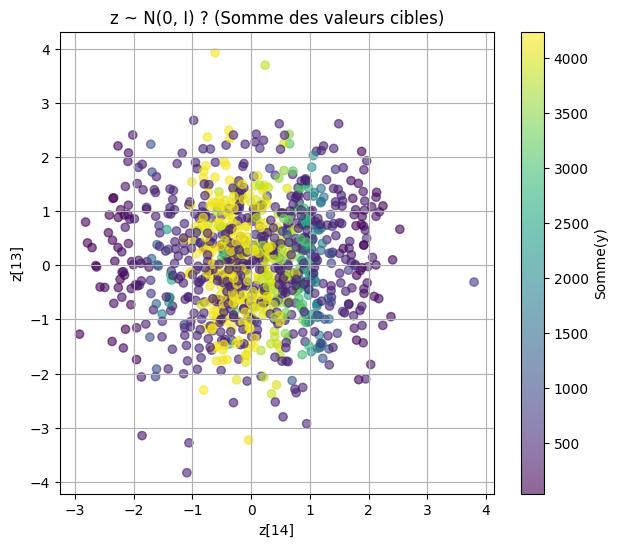

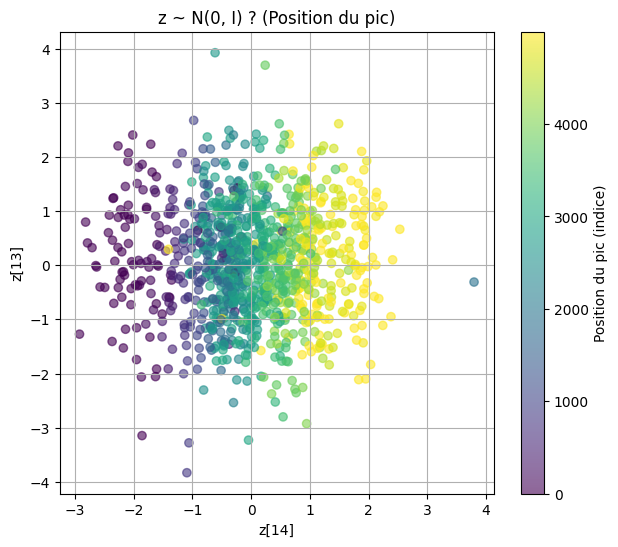

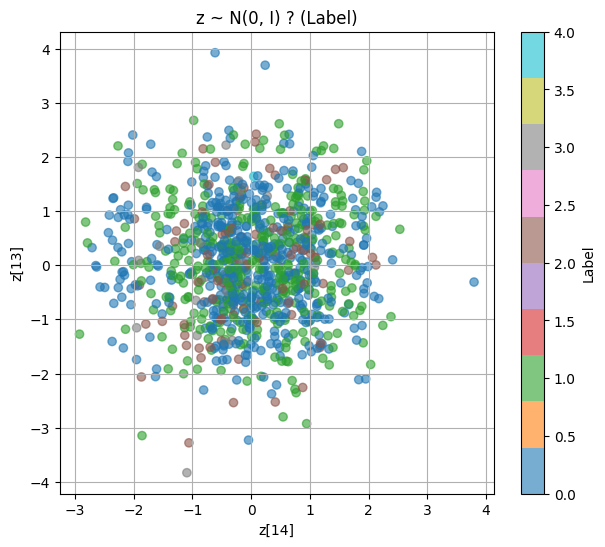

Variance moyenne de z : 1.0066696405410767
Moyenne de z : [-2.1997828e-02 -4.9662933e-02  1.4270071e-02  4.2762789e-03
 -4.3858677e-02 -2.6567005e-02  1.5686901e-02  5.5257101e-02
  6.7524817e-03 -2.8052321e-02 -2.6096024e-02  1.2487583e-03
  8.9131109e-02  6.8581671e-02 -9.8567456e-05 -3.9355859e-02
 -1.9008407e-02 -3.9182915e-03  5.7663172e-03  1.9927826e-03]


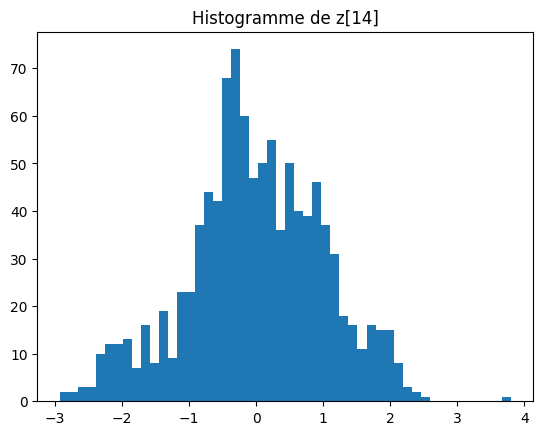

In [55]:
# Visualisation 2D des données dans l'espace latent
# ============================================================
cvae_latent_2d(cvae, dataloader_test_big, index_x=index1, index_y=index2, index_histo=index1, device=None)

In [ ]:
# Interpolation dans l'espace latent
# ============================================================
axis = index1
steps = 20
cvae_latent_interpolation(cvae, latent_dim=latent_dim, dim_x=4, axis=axis, z_min=-2, z_max=2, steps=steps, fixed_z=None, device=None)

In [56]:
# Inverse de la standardisation
recon_x_orig = scaler_x.inverse_transform(recon_x)
orig_x_orig = scaler_x.inverse_transform(orig_x)

# ============================================================
# Affichage d'exemples (ici on affiche la première donnée du batch)
# ============================================================
index = 0
print("=== Données originales ===")
print("X:", orig_x_orig[index])
print("Y:", orig_y[index])
print("\n=== Reconstruction ===")
print("X reconstruit:", recon_x_orig[index])
print("Y reconstruit:", recon_y[index])


=== Données originales ===
X: [4.000000e+02 2.000000e-01 5.000000e+02 2.513274e+06]
Y: [0.41607887 0.41630778 0.41653675 ... 0.76829225 0.7680743  0.76785624]

=== Reconstruction ===
X reconstruit: [3.7939246e+02 4.3743259e-01 1.7791200e+02 1.4731769e+07]
Y reconstruit: [0.4909484  0.4910891  0.4912665  ... 0.65532225 0.65498424 0.654286  ]


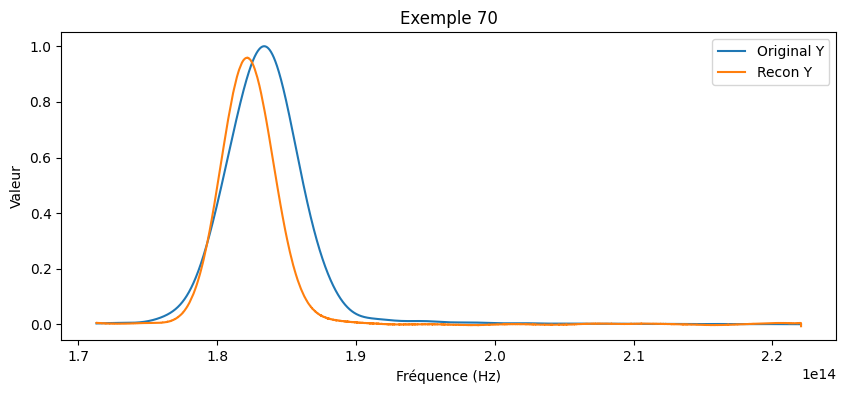

In [57]:
frequencies = np.linspace(171309976000000, 222068487407407, 5000)

i = np.random.randint(0, 100)

plt.figure(figsize=(10, 4))
plt.plot(frequencies, orig_y[i], label='Original Y')
plt.plot(frequencies, recon_y[i], label='Recon Y')
plt.title(f"Exemple {i+1}", fontsize=12)
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Valeur")
plt.legend()
plt.show()

          Donnée x ∈ ℝ⁵⁰⁰⁴
                │
           +----▼----+
           | encodeur|
           +----+----+
                │
     ┌──────────┴────────────┐
     ↓                       ↓
 mu ∈ ℝⁿˣ³²           logvar ∈ ℝⁿˣ³²
     │                       │
     └─────┬────────────┬────┘
           ↓            ↓
    std = exp(0.5*logvar)
           ↓
   z = mu + eps * std  → ℝⁿˣ³²
           ↓
     décodeur(z) → x̂ ∈ ℝⁿˣ⁵⁰⁰⁴


# Génération synthétique

In [58]:
mean = z_train.mean(dim=0)  # centre
std = z_train.std(dim=0)    # écart-type par dimension
print("Mean of z_train:", mean)
print("Std of z_train:", std) 
  
# Optionnel : matrice de covariance
cov = torch.cov(z_train.T)  # shape (latent_dim, latent_dim)
mean = mean.to(device)
std = std.to(device)
cov = cov.to(device)

Mean of z_train: tensor([ 0.0006, -0.0009,  0.0003, -0.0011,  0.0026, -0.0010,  0.0008, -0.0022,
         0.0023,  0.0017, -0.0009,  0.0008,  0.0014,  0.0018,  0.0043, -0.0014,
        -0.0026, -0.0008, -0.0003, -0.0008])
Std of z_train: tensor([0.0023, 0.0024, 0.0032, 0.0028, 0.0025, 0.0027, 0.0024, 0.0023, 0.0032,
        0.0025, 0.0022, 0.0031, 0.0022, 0.0049, 0.9912, 0.0024, 0.0033, 0.0024,
        0.0029, 0.0026])


In [68]:
from torch.distributions import MultivariateNormal

n_samples = 1000  # Nombre d'échantillons à générer
label_value = 0  # le label que tu veux générer

# Crée un tensor de labels de la bonne taille
label_tensor = torch.full((n_samples, 1), label_value, dtype=torch.float32).to(device)
mvn = MultivariateNormal(mean, covariance_matrix=cov)
z = mvn.sample((n_samples,)).to(device)

# Filtrage des z trop improbables (garde les 99% les plus probables)
log_probs = mvn.log_prob(z)
threshold = torch.quantile(log_probs, 0.01)  # Garde les 99% les plus probables
mask = log_probs > threshold
z_filtered = z[mask]
label_tensor = label_tensor[mask]

print(f"Nombre de z gardés après filtrage : {z_filtered.shape[0]} sur {n_samples} échantillons")

# Générer les données avec le décodeur à partir des z filtrés
with torch.no_grad():
    generated = cvae.decode(z_filtered, label_tensor)  # [n_samples_filtrés, input_dim]

    # Séparer X et Y générés
    generated = generated.cpu().numpy()
    gen_x = generated[:, :dim_x]
    gen_y = generated[:, dim_x:]

# Dénormaliser si besoin
gen_x_orig = scaler_x.inverse_transform(gen_x)

print("Shape X généré :", gen_x_orig.shape)
print("Shape Y généré :", gen_y.shape)

Nombre de z gardés après filtrage : 990 sur 1000 échantillons
Shape X généré : (990, 4)
Shape Y généré : (990, 5000)


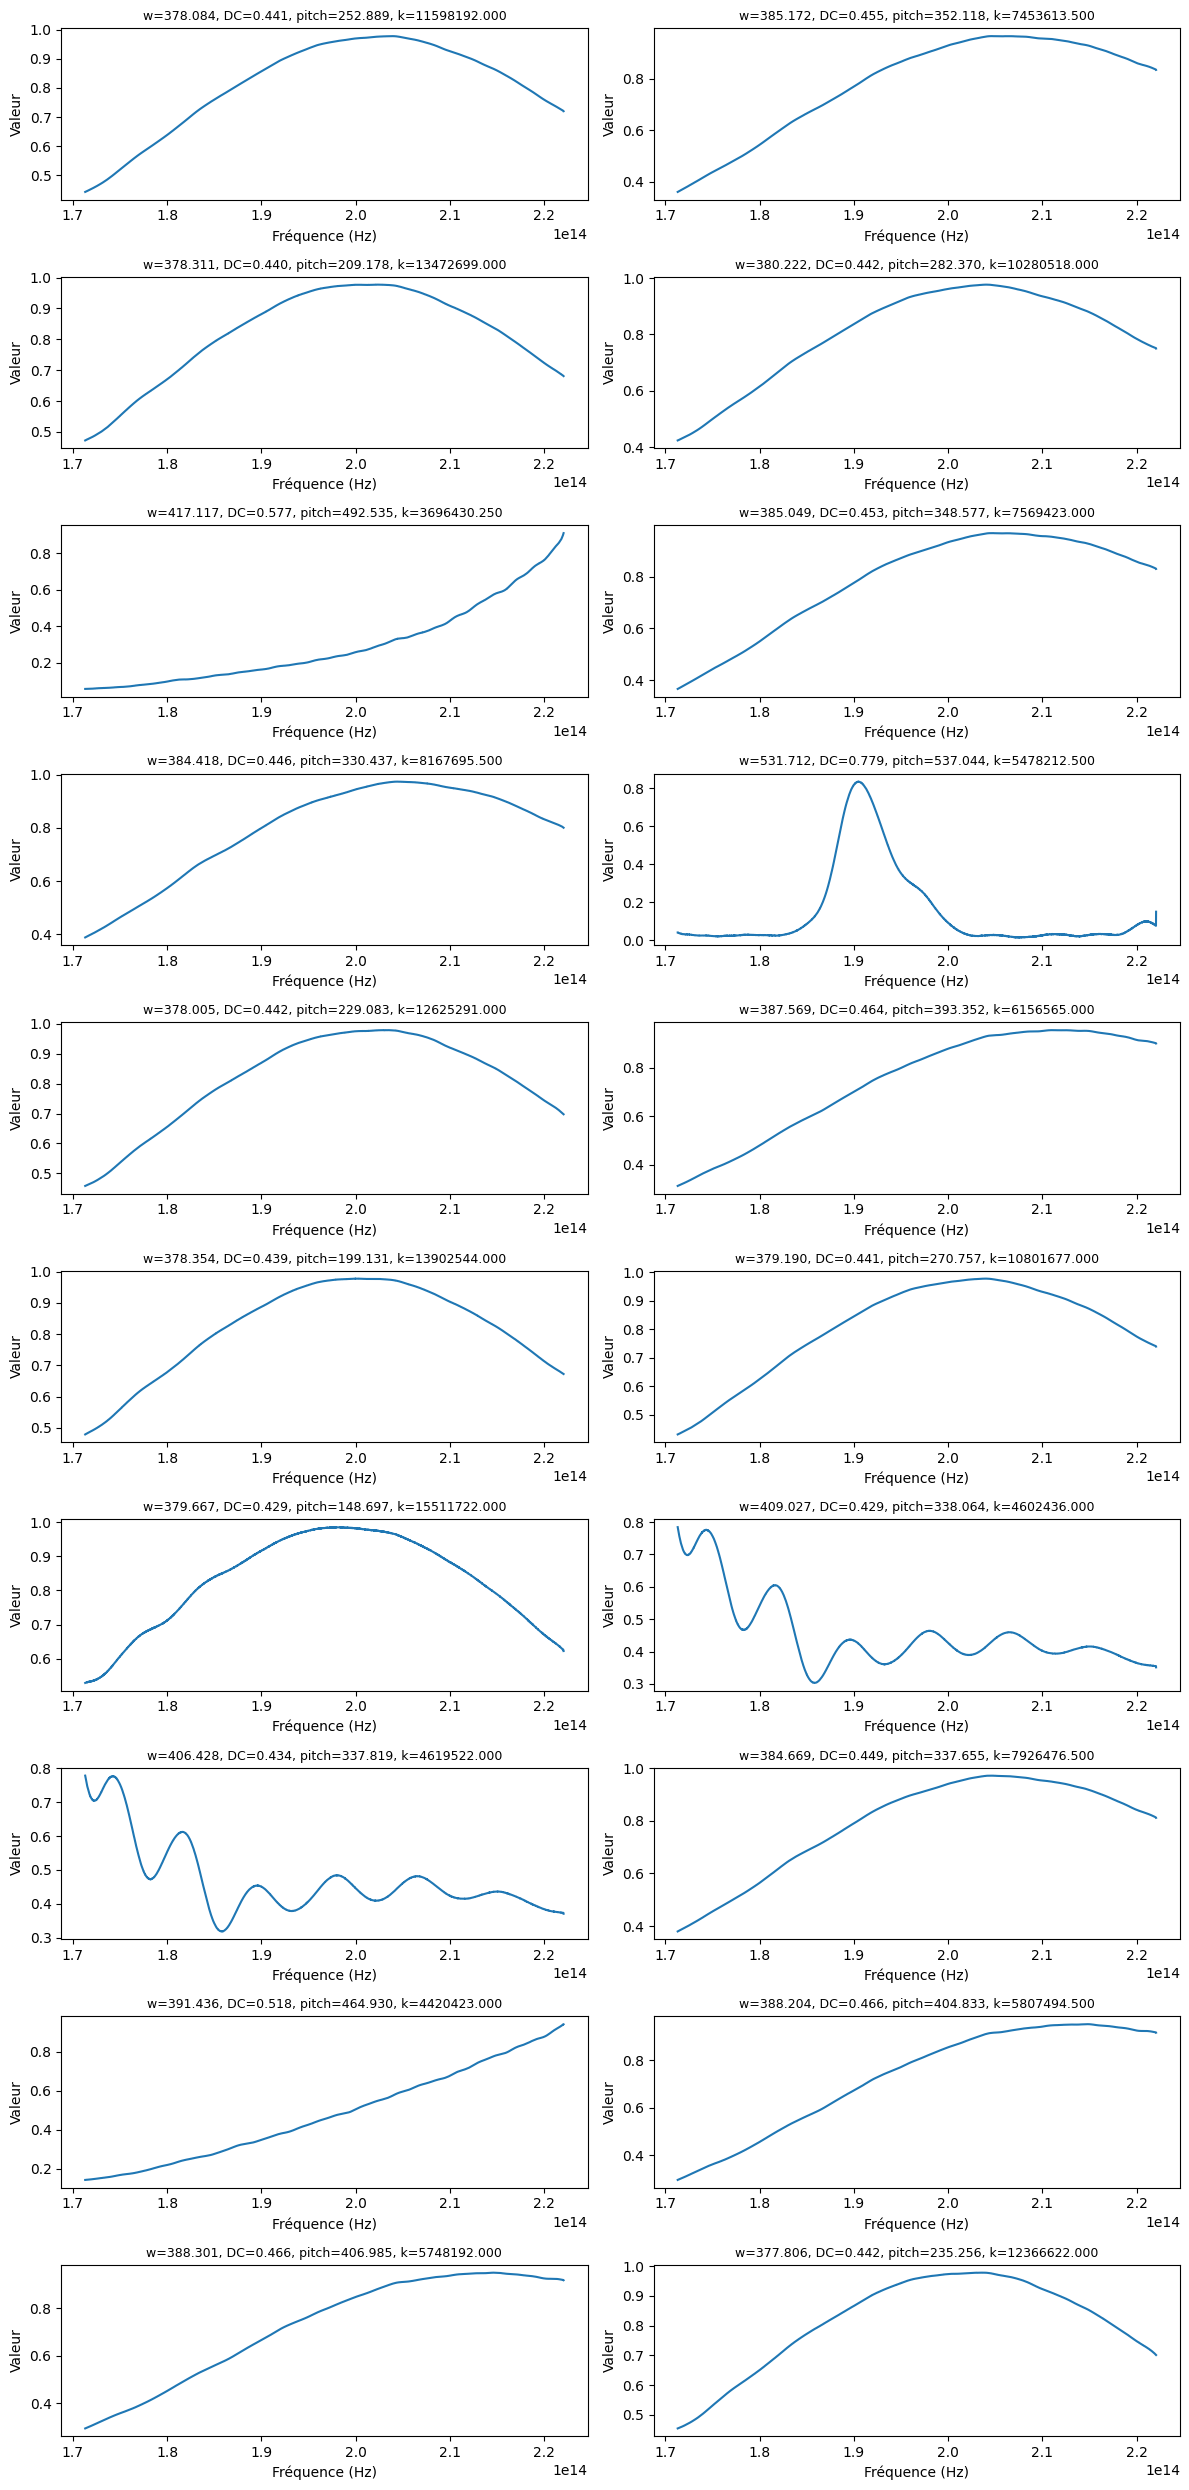

In [69]:
frequencies = np.linspace(171309976000000, 222068487407407, 5000)

# Sélectionne 10 indices aléatoires dans les données générées
n_plot = 20
indices = np.random.choice(gen_y.shape[0], n_plot, replace=False)

n_cols = 2
n_rows = n_plot // n_cols

plt.figure(figsize=(12, 2.5 * n_rows))
for idx, i in enumerate(indices):
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.plot(frequencies, gen_y[i], label='Spectre généré')
    w, DC, pitch, k = gen_x_orig[i, 0], gen_x_orig[i, 1], gen_x_orig[i, 2], gen_x_orig[i, 3]
    plt.title(f"w={w:.3f}, DC={DC:.3f}, pitch={pitch:.3f}, k={k:.3f}", fontsize=9)
    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Valeur")
    plt.tight_layout()
plt.show()

In [72]:
def count_peaks(spectre, threshold=0.1):
    above = spectre >= threshold
    # Un pic commence quand on passe de False à True
    return np.sum((~above[:-1]) & (above[1:]))

# On ajoute le cas où le tout premier point est déjà un pic
def count_peaks_full(spectre, threshold=0.1):
    above = spectre >= threshold
    # Pic au début si le premier point est au-dessus du seuil
    count = int(above[0])
    count += np.sum((~above[:-1]) & (above[1:]))
    return count

# Appliquer à tous les spectres générés
peaks_per_spectre = np.array([count_peaks_full(s, threshold=0.1) for s in gen_y])

# Statistiques
unique, counts_unique = np.unique(peaks_per_spectre, return_counts=True)
print("Répartition du nombre de pics par spectre généré :")
for u, c in zip(unique, counts_unique):
    print(f"{u} pics : {c} spectres")

Répartition du nombre de pics par spectre généré :
1 pics : 908 spectres
2 pics : 44 spectres
3 pics : 21 spectres
4 pics : 3 spectres
5 pics : 4 spectres
6 pics : 4 spectres
7 pics : 1 spectres
9 pics : 1 spectres
15 pics : 1 spectres
16 pics : 1 spectres
18 pics : 1 spectres
23 pics : 1 spectres


In [31]:
# Sélectionner uniquement les spectres générés avec 1 pic

# peaks_per_spectre a été calculé précédemment
mask_1pic = (peaks_per_spectre == 1)
gen_x_1pic = gen_x_orig[mask_1pic]
gen_y_1pic = gen_y[mask_1pic]

print("Nombre de spectres générés avec 1 pic :", gen_x_1pic.shape[0])
print("Shape X généré avec 1 pic :", gen_x_1pic.shape)
print("Shape Y généré avec 1 pic :", gen_y_1pic.shape)

Nombre de spectres générés avec 1 pic : 690
Shape X généré avec 1 pic : (690, 4)
Shape Y généré avec 1 pic : (690, 5000)


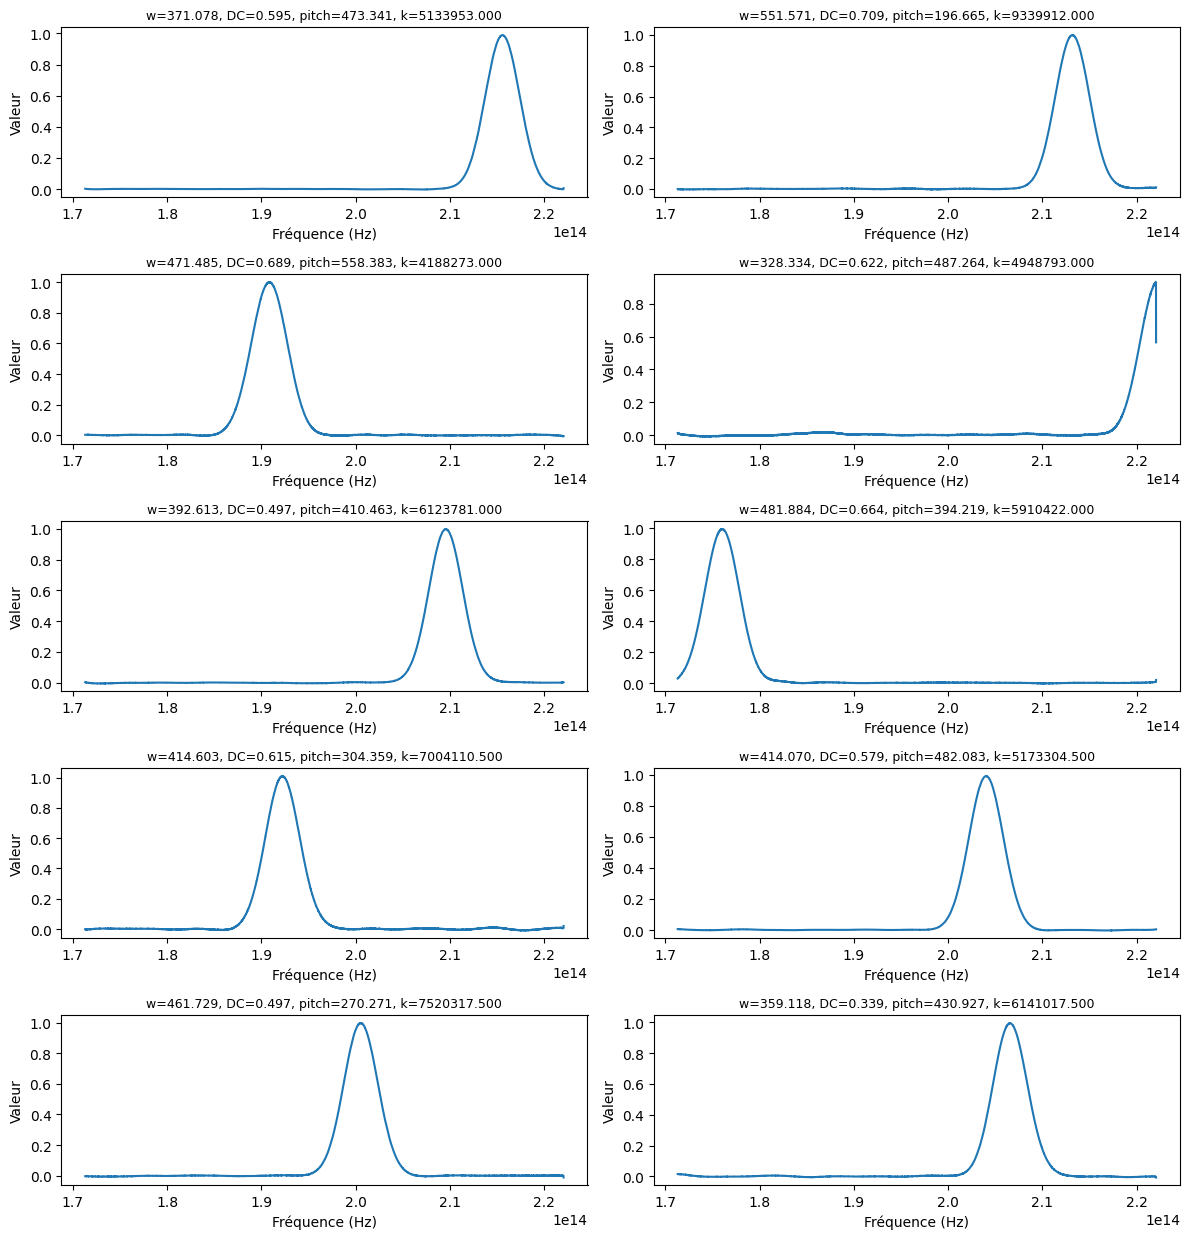

In [32]:
frequencies = np.linspace(171309976000000, 222068487407407, 5000)

# Sélectionne 10 indices aléatoires dans les données générées
n_plot = 10
indices = np.random.choice(gen_y_1pic.shape[0], n_plot, replace=False)

n_cols = 2
n_rows = n_plot // n_cols

plt.figure(figsize=(12, 2.5 * n_rows))
for idx, i in enumerate(indices):
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.plot(frequencies, gen_y_1pic[i], label='Spectre généré')
    w, DC, pitch, k = gen_x_1pic[i, 0], gen_x_1pic[i, 1], gen_x_1pic[i, 2], gen_x_1pic[i, 3]
    plt.title(f"w={w:.3f}, DC={DC:.3f}, pitch={pitch:.3f}, k={k:.3f}", fontsize=9)
    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Valeur")
    plt.tight_layout()
plt.show()

n_eff shape: (690,)
Exemples de n_eff: [1.25917296 1.05979078 1.55994092 1.82866863 1.44038684 1.46499615
 2.20985266 0.92720053 1.33269201 1.47170264]


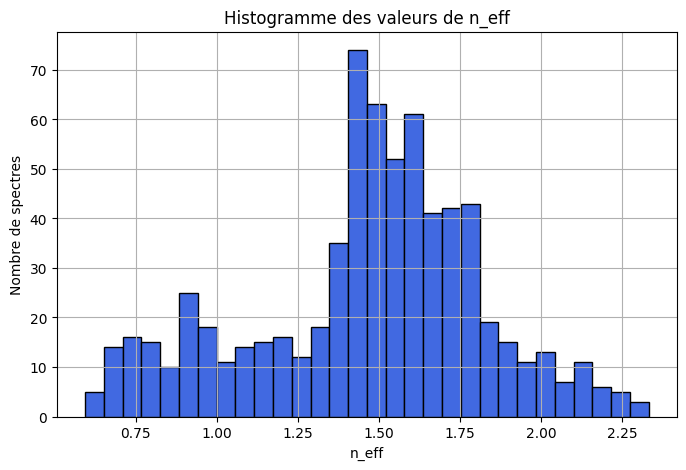

In [35]:
c = 299792458  # vitesse de la lumière en m/s

n_eff_list = []
for i in range(gen_x_1pic.shape[0]):
    spectre = gen_y_1pic[i]
    idx_peak = np.argmax(spectre)
    f_res = frequencies[idx_peak]
    k = gen_x_1pic[i, 3]
    omega = 2 * np.pi * f_res
    n_eff = c * k / omega

    n_eff_list.append(n_eff)

n_eff_array = np.array(n_eff_list)
print("n_eff shape:", n_eff_array.shape)
print("Exemples de n_eff:", n_eff_array[:10])

plt.figure(figsize=(8, 5))
plt.hist(n_eff_array, bins=30, color='royalblue', edgecolor='black')
plt.xlabel("n_eff")
plt.ylabel("Nombre de spectres")
plt.title("Histogramme des valeurs de n_eff")
plt.grid(True)
plt.show()

### Data augmentation

Shape de x_data : (3590, 4)
Shape de y_data après normalisation : (3590, 5000)


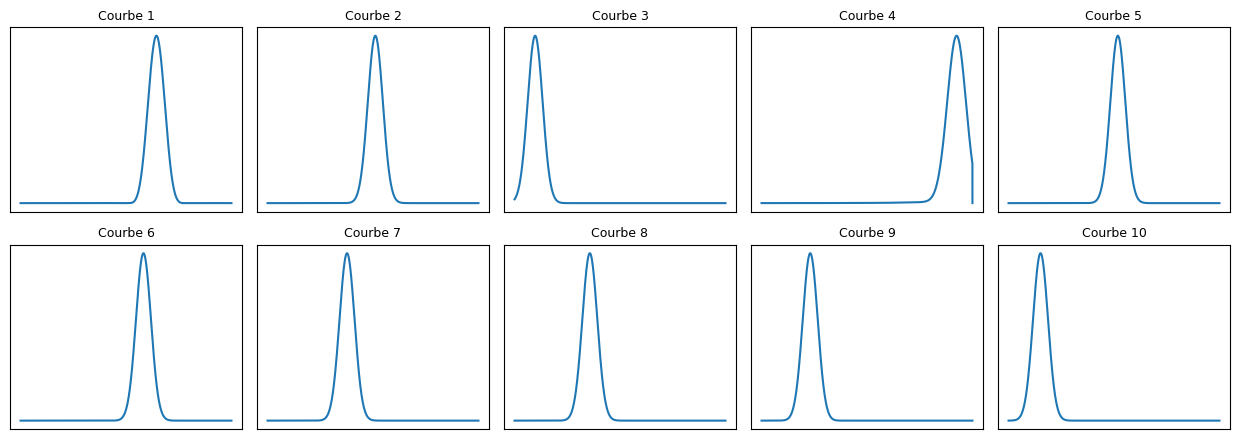

In [ ]:
# Chargement des données
#x_data = np.load('data/X_data_array_5000.npy')
#y_data = np.load('data/y_data_array_5000.npy')

# Réduction de Y : on prend 1 point sur 10 (axis=1)
#y_data = y_data[:, ::10]  # (n, 500)

# --- Normalisation au pic pour chaque spectre ---
y_max = np.max(y_data, axis=1, keepdims=True)
y_max[y_max == 0] = 1  # éviter division par zéro
y_data = y_data / y_max

print("Shape de x_data :", x_data.shape)
print("Shape de y_data après normalisation :", y_data.shape)

# Affichage des 30 premières courbes, une par subplot
n_examples = 10
n_cols = 5
n_rows = 6

plt.figure(figsize=(2.5*n_cols, 2.2*n_rows))
for i in range(n_examples):
    plt.subplot(n_rows, n_cols, i+1)
    plt.plot(np.arange(1, 5001), y_data[i])
    plt.title(f"Courbe {i+1}", fontsize=9)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [127]:
x_data_aug = np.concatenate([x_data, gen_x_1pic], axis=0)
y_data_aug = np.concatenate([y_data, gen_y_1pic], axis=0)

from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
x_data_aug = scaler_x.fit_transform(x_data_aug)

print("Nouvelle taille de x_data :", x_data_aug.shape)
print("Nouvelle taille de y_data :", y_data_aug.shape)
print("Moyenne de x_data :", x_data_aug.mean(axis=0))
print("Écart-type de x_data :", x_data_aug.std(axis=0))

Nouvelle taille de x_data : (7309, 4)
Nouvelle taille de y_data : (7309, 5000)
Moyenne de x_data : [ 1.8708552e-06  2.7773569e-07 -2.7663989e-07  1.3827865e-07]
Écart-type de x_data : [1.0000011 0.9999965 1.0000007 0.9999988]


# FNN Training

In [112]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from FNN.feedforwardNN import FeedforwardNN

In [129]:
# Hyperparamètres
input_dim = 4
output_dim = 5000
hidden_dim_list = [955, 925, 1005, 407, 580, 1309]
dropout = 0.01
lr = 1.6e-3
batch_size = 128
num_epochs = 1000

In [131]:
# Préparation des données
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

x_tensor = torch.tensor(x_data_aug, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_data_aug, dtype=torch.float32).to(device)
dataset = TensorDataset(x_tensor, y_tensor)
# Split train/val (par exemple 80/20)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset)) 
print("Exemple de batch :")
data_iter = iter(train_loader)
X_batch, y_batch = next(data_iter)
print("X_batch shape:", X_batch.shape)
print("y_batch shape:", y_batch.shape)


Using device: cuda
Train dataset size: 5848
Validation dataset size: 1461
Exemple de batch :
X_batch shape: torch.Size([128, 4])
y_batch shape: torch.Size([128, 5000])


Epoch 1/1000 - Train Loss: 0.0568 - Val Loss: 0.0518
Epoch 2/1000 - Train Loss: 0.0493 - Val Loss: 0.0454
Epoch 3/1000 - Train Loss: 0.0403 - Val Loss: 0.0344
Epoch 4/1000 - Train Loss: 0.0324 - Val Loss: 0.0294
Epoch 5/1000 - Train Loss: 0.0265 - Val Loss: 0.0260
Epoch 6/1000 - Train Loss: 0.0224 - Val Loss: 0.0199
Epoch 7/1000 - Train Loss: 0.0181 - Val Loss: 0.0144
Epoch 8/1000 - Train Loss: 0.0162 - Val Loss: 0.0137
Epoch 9/1000 - Train Loss: 0.0150 - Val Loss: 0.0124
Epoch 10/1000 - Train Loss: 0.0122 - Val Loss: 0.0110
Epoch 11/1000 - Train Loss: 0.0117 - Val Loss: 0.0123
Epoch 12/1000 - Train Loss: 0.0110 - Val Loss: 0.0091
Epoch 13/1000 - Train Loss: 0.0117 - Val Loss: 0.0083
Epoch 14/1000 - Train Loss: 0.0107 - Val Loss: 0.0089
Epoch 15/1000 - Train Loss: 0.0094 - Val Loss: 0.0078
Epoch 16/1000 - Train Loss: 0.0090 - Val Loss: 0.0071
Epoch 17/1000 - Train Loss: 0.0084 - Val Loss: 0.0070
Epoch 18/1000 - Train Loss: 0.0088 - Val Loss: 0.0067
Epoch 19/1000 - Train Loss: 0.0081 - 

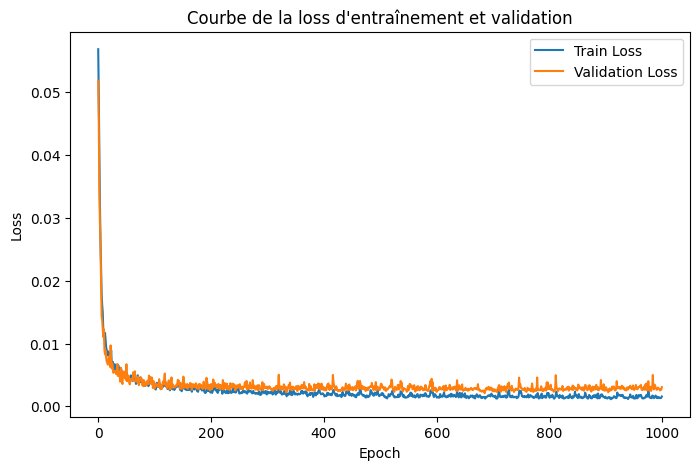

In [ ]:
# Modèle
model = FeedforwardNN(input_dim, output_dim, hidden_dim_list, dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

train_losses = []
val_losses = []

# Entraînement
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)  # <-- passage sur CUDA
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)  # <-- passage sur CUDA
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

# Affichage des courbes de loss
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de la loss d'entraînement et validation")
plt.legend()
plt.show()

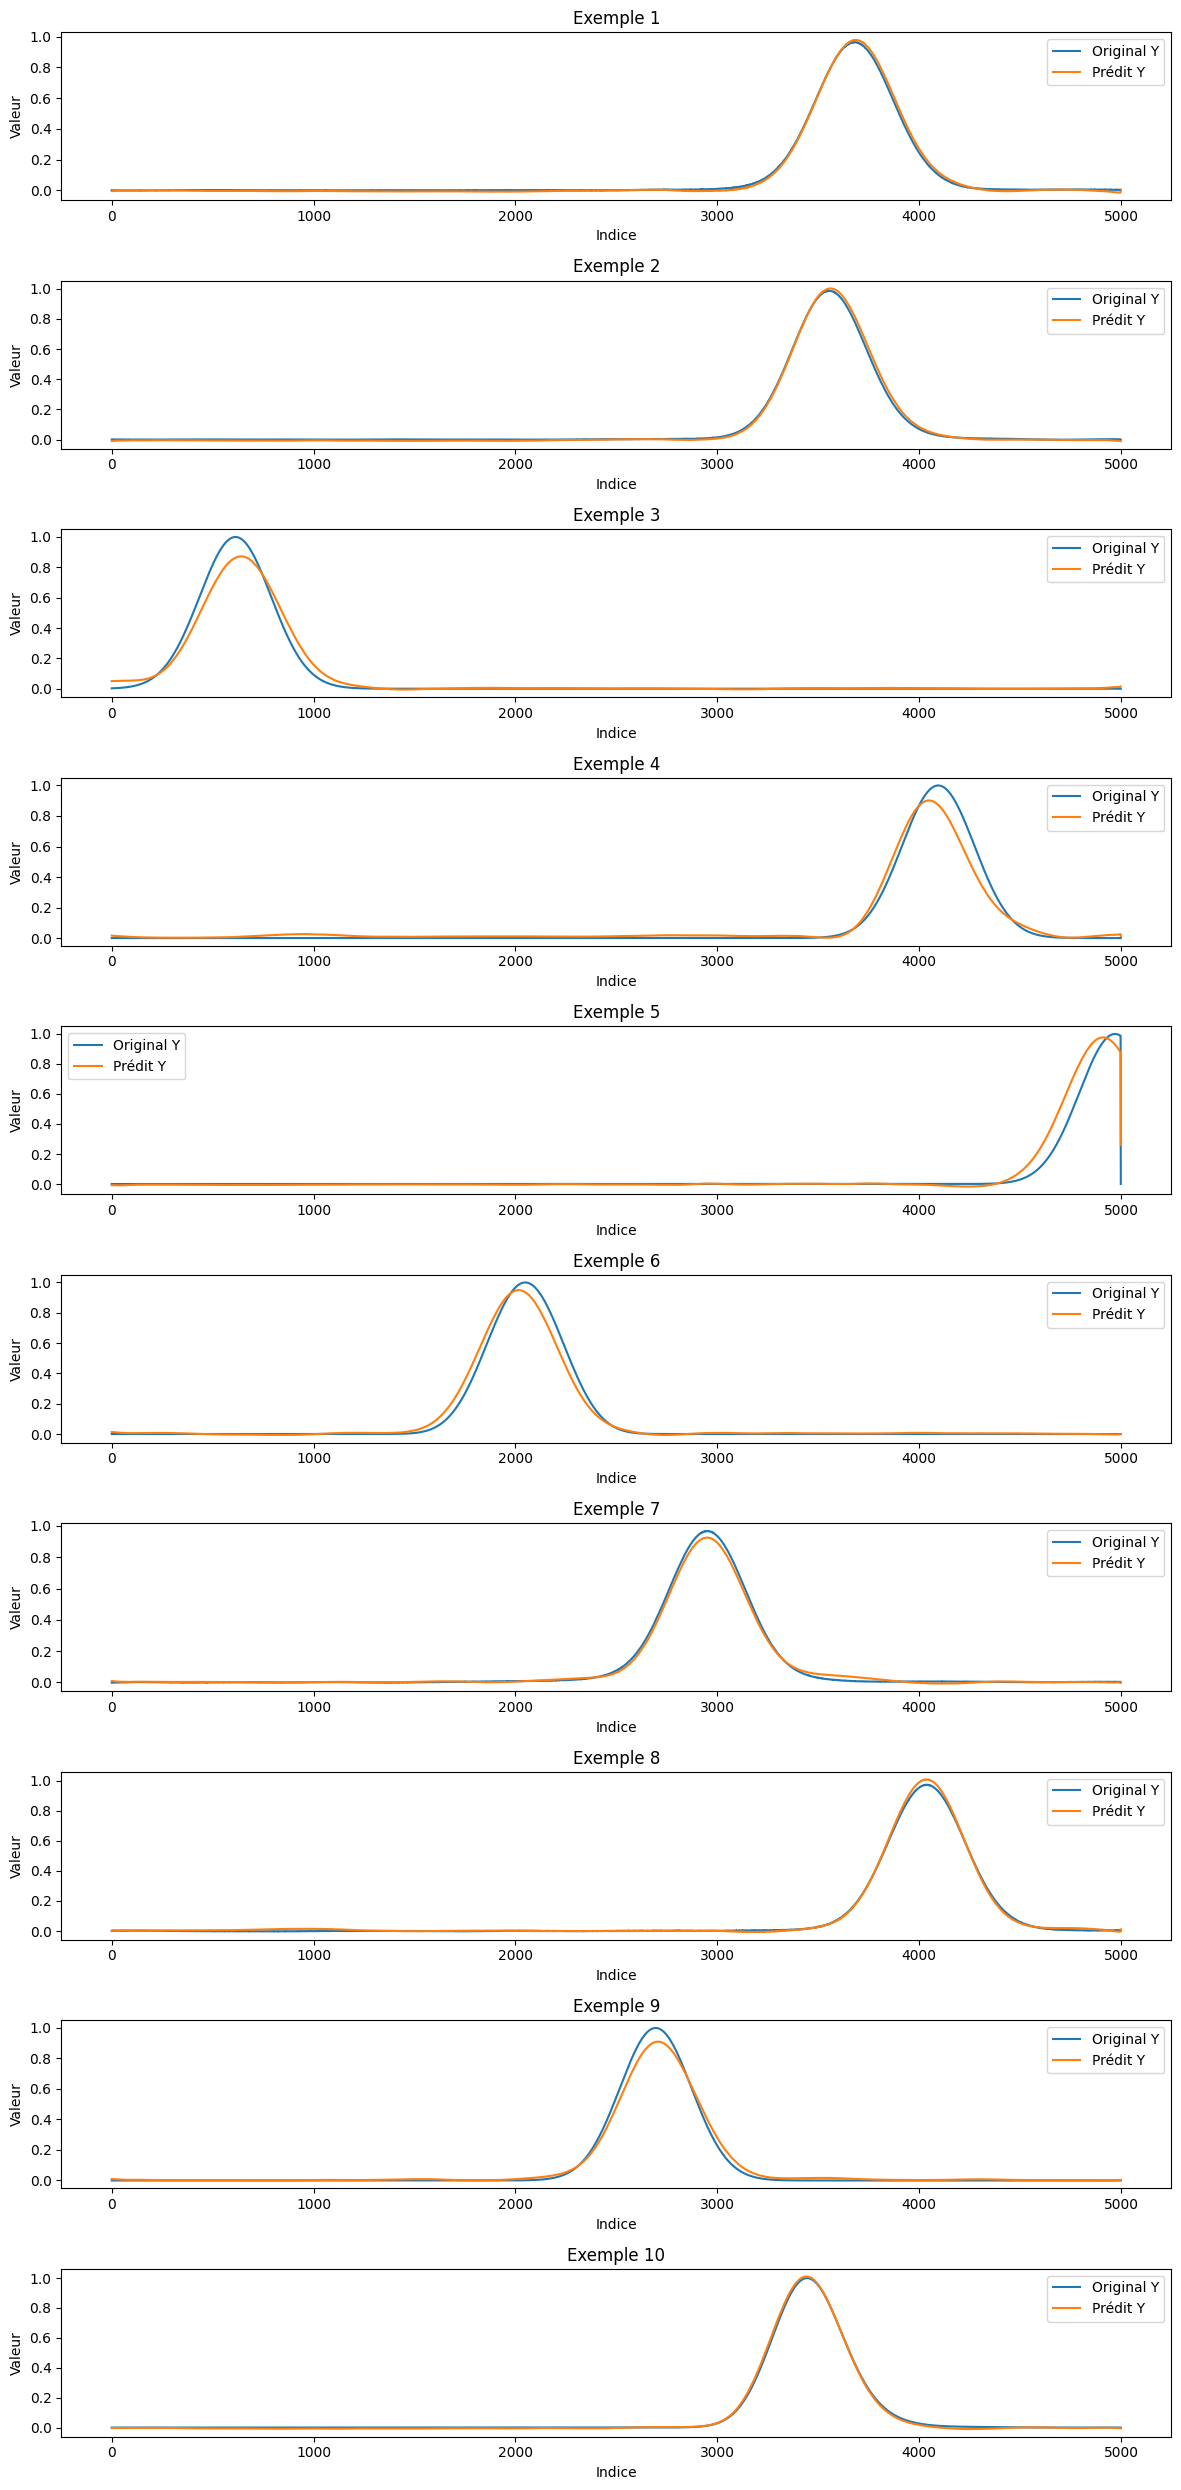

In [133]:
# Mode évaluation et affichage de quelques spectres prédits vs originaux

model.eval()
n_examples = 10  # nombre d'exemples à afficher

with torch.no_grad():
    # On prend un batch de validation
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred_y = model(xb)
        break  # On ne prend que le premier batch

# Conversion en numpy pour affichage
xb_np = xb.cpu().numpy()
yb_np = yb.cpu().numpy()
pred_y_np = pred_y.cpu().numpy()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 2.5 * n_examples))
for i in range(n_examples):
    plt.subplot(n_examples, 1, i+1)
    plt.plot(yb_np[i], label='Original Y')
    plt.plot(pred_y_np[i], label='Prédit Y')
    plt.title(f"Exemple {i+1}")
    plt.xlabel("Indice")
    plt.ylabel("Valeur")
    plt.legend()
plt.tight_layout()
plt.show()